# Tracking sperm using trackpy

This is a short tutorial how to use the trackpy API to track sperm cells. It is meant as a guidance and has to be adapted to the output from your microscope.

The authors of the trackpy library offer more in depth tutorials which can be found [here](http://soft-matter.github.io/trackpy/v0.5.0/tutorial.html)


Requirements:

- python 3.8 (we recommend using [anaconda](https://www.anaconda.com/products/individual) to create a new conda [environment](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html)
- trackpy 5.0 ([installation instructions](http://soft-matter.github.io/trackpy/v0.5.0/installation.html))
- jupyterlab ([installation instructions](https://jupyter.org/install))

## First we load required python libraries

In [17]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pims
import trackpy as tp

mpl.rc('figure', figsize = (10,10))

## Then we load the images using ```pims.open()``` and a wildcard ("*")

Download the example images from the github repository.

Please change the path to the correct path where you stored the example images

In [11]:
images = pims.open('/your/path/to/Images/A01/*.tif')

## We can see that our ```images``` object contains 23 frames as well as the dimensions and pixel datatype

In [32]:
images

<Frames>
Source: /local_data/CV7000/test/A01/*.tif
Length: 23 frames
Frame Shape: (720, 853)
Pixel Datatype: uint16

## We can also have a look at a single frame

We are using a CV7000 high-content reader, with a 20x objective, and 3x3 binning to achieve a frame-rate of about 45 FPS. Below we describe how certain arguments of trackpy need to be adjusted for images from different micrscopes.

Frame([[4435, 4450, 4615, ..., 3654, 3700, 3580],
       [4253, 4002, 4193, ..., 3477, 3625, 3662],
       [4273, 4166, 4087, ..., 3609, 3598, 3577],
       ...,
       [4234, 4148, 4260, ..., 3663, 3589, 3489],
       [4298, 4160, 4178, ..., 3491, 3571, 3675],
       [4343, 4123, 4312, ..., 3670, 3655, 3679]], dtype=uint16)
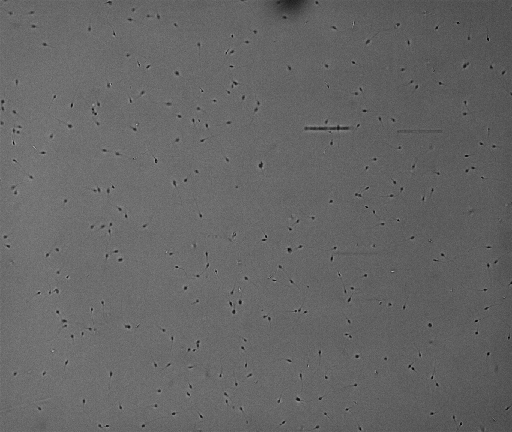

In [33]:
images[0]

## Here we specify parameters for detecting sperm heads

Head diameter in pixel, has to be an odd integer.

Minmass (```mm```) is used as a filter to remove particles below certain total brightness levels.

Both parameters are used in the ```tp.locate()``` function. In case the images at hand are white sperm heads on dark background, set the ```invert``` argument to ```False```. 

The result will be a pandas dataframe containing x,y coordinates for each detected particle, along with several particle features (total intensity, size, eccentricity, ...).

```tp.annotate()``` allows to inspect the detected sperm heads. This does not need to be perfect, but we want to see most of the sperm heads encircled.

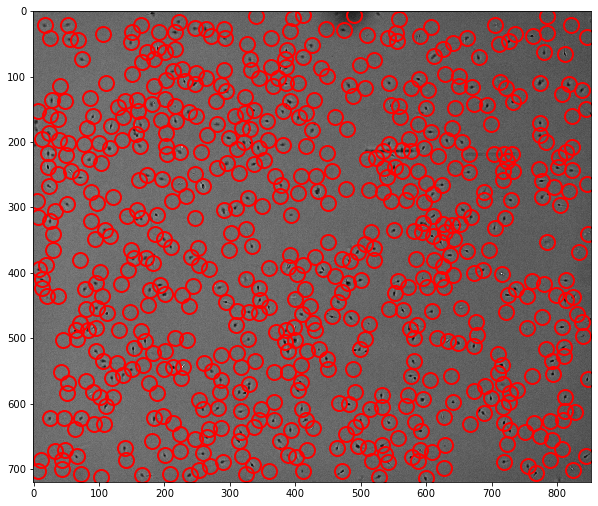

<AxesSubplot:>

In [34]:
#sperm head diameter
head_diameter = 11

#total pixel intensity. this value will be different for every microscope/camera
mm = 1500

sperm_heads = tp.locate(images[0], diameter = head_diameter, invert = True, minmass = mm)
tp.annotate(sperm_heads, images[0])

In [35]:
all_frames = tp.batch(images[:], diameter = head_diameter, invert = True, minmass = mm)

Frame 22: 633 features


## We can summarize our result using the ```pandas.DataFrame.describe``` method

In [36]:
all_frames.describe()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
count,14315.000000,14315.000000,14315.000000,14315.000000,14315.000000,14315.000000,1.431500e+04,14315.000000,14315.000000
mean,357.154290,408.223517,8479.186143,2.438212,0.275578,587.625892,4.980823e+06,-0.337035,10.999790
std,206.000934,239.840660,7825.951315,0.486237,0.132482,560.235222,1.759243e+04,49.444770,6.643673
min,4.471620,4.337791,1500.000507,1.287398,0.003914,48.365383,4.943860e+06,-4705.464692,0.000000
25%,182.590242,202.059951,1718.243915,1.977935,0.179387,91.715048,4.967217e+06,-0.543612,5.000000
50%,352.465102,393.745038,3160.560365,2.489221,0.256850,183.130271,4.978585e+06,-0.324593,11.000000
75%,534.182406,609.810445,16142.466261,2.853999,0.357590,1197.785177,4.992736e+06,-0.225858,17.000000
max,714.533887,847.199996,39405.487189,3.706366,0.776560,1896.455787,5.099244e+06,3262.849048,22.000000


## We can use the table above as a guidance to select against wrongly detected sperm heads

Here we use a size and signal cut-off. We can see that this mainly retains sperm heads. Please not there will be some sperm heads not detected or some red circles with now sperm head. You have to find a compromise for your data, and test on multiple image sets.

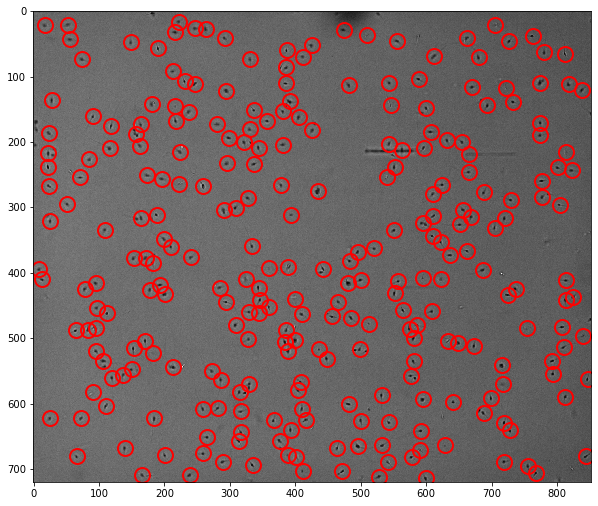

<AxesSubplot:>

In [47]:
filtered_heads = all_frames.loc[(all_frames['size'] < 2.7) & 
                                (all_frames['signal'] > 250)]

tp.annotate(filtered_heads.loc[filtered_heads.frame==0], images[0])

## Now we need to link each sperm track over all frames

We need to optimize ```search_range``` and ```memory``` arguments for optimal tracking results.

In [49]:
#maximum displacement of a sperm track between frames
sperm_search_range = 5

#maximum allowed frames a sperm track can be "missing" (e.g. out of focal plane)
disappeared_frames = 3

sperm_tracks = tp.link(filtered_heads, search_range = sperm_search_range, memory = disappeared_frames)

Frame 22: 288 trajectories present.


## As a last step we can use ```tp.filter_stubs``` to remove sperm tracks only visible for a few frames

Our dataset has 23 frames, so we could remove any sperm tracks which are not present in at least 20 frames.

In [64]:
#minimum amount of frames a sperm track has to be present
minimum_frames = 20

filtered_tracks = tp.filter_stubs(sperm_tracks, threshold = minimum_frames)

## We can then visualize sperm tracks with another convenient function from the trackpy API ```tp.plot_traj()```

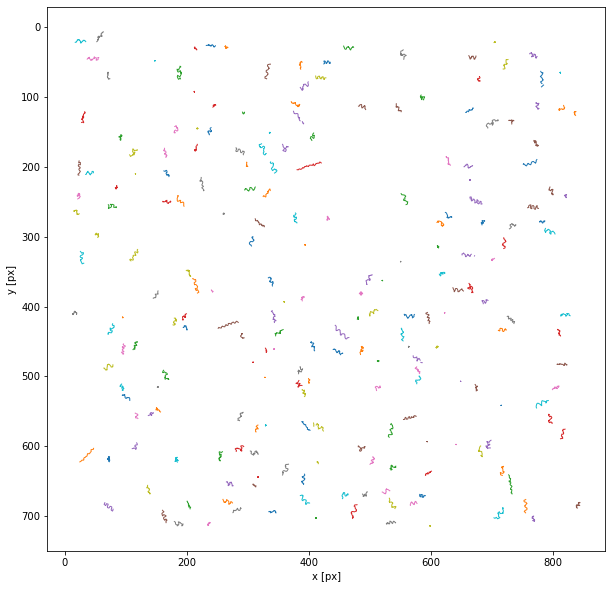

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [69]:
tp.plot_traj(filtered_tracks)

## Last we save the csv file for kinematic analysis

In [ ]:
output_path = '/your/path/here'
filtered_tracks.to_csv(output_path)

In [71]:
filtered_tracks.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,466.713603,455.766556,15109.435188,1.943639,0.449650,1340.652460,4980447.0,-0.603895,0,1
0,468.620444,485.035603,18964.892951,2.080463,0.320030,1331.651763,4992340.0,-2.449685,0,2
0,477.686841,512.641228,4952.374540,1.415983,0.173868,671.441360,4979015.0,-0.553664,0,3
0,479.719142,308.773316,22263.502296,1.905434,0.083183,1493.584653,4983532.0,-0.750599,0,4
0,480.243499,586.201977,15442.991984,1.776655,0.263512,1281.152278,4989670.0,-1.452797,0,5


## Final thoughts

In this short tutorial we have explained how to use the trackpy API to track sperm cells from short time-lapse movies. We have been using trackpy for convenience. It is straightforward to use and can be adapted to run on a computational cluster.

Using the results from trackpy, one can continue to calculate sperm kinematics using the x and y coordinates for each sperm track. This can be done in multiple ways. 

E.g. one could adapt our R code, which we provide in the original eLife paper [here](https://cdn.elifesciences.org/articles/51739/elife-51739-fig2-code1-v2.r).

We also provide a small example calculating VCL below

## Get the number of frames per particle and add total time column


In [112]:
#interval time between frames; here 0.02 sec
interval_time = 0.02

filtered_tracks['n_frames'] = filtered_tracks.groupby('particle')['frame'].transform('nunique')
filtered_tracks['total_time'] = filtered_tracks.n_frames * interval_time

## Calculate VCL per particle and store in a separate Data Frame

For each sperm track we calculate the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and divide by the tracks ```total time```

In [ ]:
kinematics_df = pd.DataFrame()

for sperm_track in filtered_tracks.particle.unique():
    
    sub_df = filtered_tracks.loc[filtered_tracks.particle == sperm_track]
    sub_diff = sub_df[['x', 'y']].diff()
    sub_norm = np.linalg.norm(sub_diff, axis = 1)
    
    sub_df['vcl'] = np.nansum(sub_norm) / sub_df.total_time.max()
    kinematics_df = kinematics_df.append(sub_df[['particle', 'vcl']][0:1])
    
    

## Plot the distrubtion of VCL [pixel/sec]

<AxesSubplot:ylabel='Frequency'>

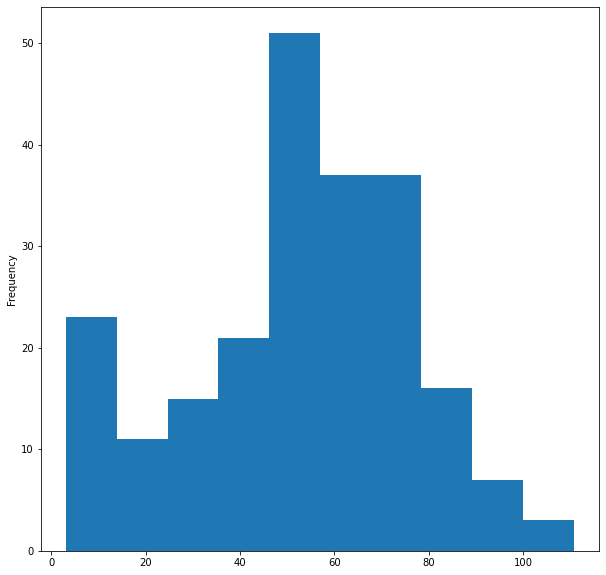

In [140]:
kinematics_df.vcl.plot(kind = 'hist')